<a href="https://colab.research.google.com/github/JanaAhmedHussien/Khadrawi/blob/main/Hackathon_Mansoura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [18]:
# ============================
# Dataset Paths
# ============================
train_dir = r"/kaggle/input/plant-disease-detection-dataset/train"
valid_dir = r"/kaggle/input/plant-disease-detection-dataset/valid"
test_dir  = r"/kaggle/input/plant-disease-detection-dataset/test"

In [19]:
# ============================
# Image Transformations
# ============================
img_size = 224
batch_size = 32


train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [20]:
# ============================
# Load Datasets
# ============================
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
#test_data  = datasets.ImageFolder(test_dir,  transform=valid_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=4)
#test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=4)

num_classes = len(train_data.classes)
print("Classes:", train_data.classes)


Classes: ['Apple', 'Cherry', 'Corn', 'Grape', 'Peach', 'Pepper', 'Potato', 'Strawberry', 'Tomato']


In [21]:
import os
import shutil

def flatten_dataset(src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)

    for crop in os.listdir(src_dir):
        crop_path = os.path.join(src_dir, crop)
        if not os.path.isdir(crop_path):
            continue

        for disease in os.listdir(crop_path):
            disease_path = os.path.join(crop_path, disease)
            if not os.path.isdir(disease_path):
                continue

            class_name = f"{crop}___{disease}".replace(" ", "_")
            class_dir = os.path.join(dest_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            for img in os.listdir(disease_path):
                src_img = os.path.join(disease_path, img)
                dst_img = os.path.join(class_dir, img)
                shutil.copy(src_img, dst_img)

    print(f"Flattened: {src_dir} → {dest_dir}")


In [22]:
# Paths
TRAIN_SRC = "/kaggle/input/plant-disease-detection-dataset/train"
VALID_SRC = "/kaggle/input/plant-disease-detection-dataset/valid"

TRAIN_DEST = "/kaggle/working/train_flat"
VALID_DEST = "/kaggle/working/valid_flat"

flatten_dataset(TRAIN_SRC, TRAIN_DEST)
flatten_dataset(VALID_SRC, VALID_DEST)


Flattened: /kaggle/input/plant-disease-detection-dataset/train → /kaggle/working/train_flat
Flattened: /kaggle/input/plant-disease-detection-dataset/valid → /kaggle/working/valid_flat


In [23]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(
    TRAIN_DEST,
    transform=train_transform
)

valid_data = datasets.ImageFolder(
    VALID_DEST,
    transform=valid_transform
)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)


In [24]:
assert train_data.classes == valid_data.classes, " Class mismatch!"
print(" Train & Valid classes match perfectly")

 Train & Valid classes match perfectly


In [25]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [26]:
# ============================
# Load Datasets
# ============================
train_data = datasets.ImageFolder(TRAIN_DEST, transform=train_transform)
valid_data = datasets.ImageFolder(VALID_DEST, transform=valid_transform)
#test_data  = datasets.ImageFolder(test_dir,  transform=valid_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=4)
#test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=4)

num_classes = len(train_data.classes)
print("Classes:", train_data.classes)


Classes: ['Apple___Apple_Scab', 'Apple___Black_Rot', 'Apple___Cedar_Apple_Rust', 'Apple___Healthy', 'Cherry___Healthy', 'Cherry___Powdery_Mildew', 'Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_Rot', 'Grape___Esca', 'Grape___Healthy', 'Grape___Leaf_Blight', 'Peach___Bacterial_Spot', 'Peach___Healthy', 'Pepper___Bacterial_Spot', 'Pepper___Healthy', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Strawberry___Healthy', 'Strawberry___Leaf_Scorch', 'Tomato___Bacterial_Spot', 'Tomato___Early_Blight', 'Tomato___Healthy', 'Tomato___Late_Blight']


In [27]:
#---------------------------------------- NOT EXECUTED HERE -------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()

        # ----------------------------
        # Feature extractor
        # ----------------------------
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 112x112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 56x56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28x28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 14x14

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # 1x1
        )

        # ----------------------------
        # Classifier (equivalent to ResNet fc)
        # ----------------------------
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneralizedPlantCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def conv_block(in_c, out_c, drop):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout2d(drop)
            )

        self.stage1 = conv_block(3, 32, 0.10)
        self.stage2 = conv_block(32, 64, 0.15)
        self.stage3 = conv_block(64, 128, 0.20)
        self.stage4 = conv_block(128, 256, 0.25)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stage1(x)   # 112x112
        x = self.stage2(x)   # 56x56
        x = self.stage3(x)   # 28x28
        x = self.stage4(x)   # 14x14
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [29]:
model = GeneralizedPlantCNN(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [30]:
# ============================
# Loss, Optimizer, Scheduler
# ============================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=15
)
scheduler.step()

scaler = GradScaler("cuda")

In [31]:
# ============================
# Training & Validation
# ============================
epochs = 15
best_val_acc = 0.0
train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

if __name__ == "__main__":
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(valid_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        scheduler.step()

        print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            torch.save(model.state_dict(), "best_crop_model.pth")
            best_val_acc = val_acc
            print(" Model saved with improved validation accuracy.")

    print("\nTraining complete.")


Epoch 1/15


100%|██████████| 1562/1562 [02:29<00:00, 10.44it/s]


Train Acc: 44.73% | Val Acc: 69.90%
 Model saved with improved validation accuracy.

Epoch 2/15


100%|██████████| 1562/1562 [02:30<00:00, 10.40it/s]


Train Acc: 66.16% | Val Acc: 84.64%
 Model saved with improved validation accuracy.

Epoch 3/15


100%|██████████| 1562/1562 [02:30<00:00, 10.40it/s]


Train Acc: 75.77% | Val Acc: 88.28%
 Model saved with improved validation accuracy.

Epoch 4/15


100%|██████████| 1562/1562 [02:30<00:00, 10.40it/s]


Train Acc: 81.23% | Val Acc: 91.49%
 Model saved with improved validation accuracy.

Epoch 5/15


100%|██████████| 1562/1562 [02:30<00:00, 10.40it/s]


Train Acc: 84.23% | Val Acc: 93.52%
 Model saved with improved validation accuracy.

Epoch 6/15


100%|██████████| 1562/1562 [02:30<00:00, 10.39it/s]


Train Acc: 86.79% | Val Acc: 94.53%
 Model saved with improved validation accuracy.

Epoch 7/15


100%|██████████| 1562/1562 [02:30<00:00, 10.39it/s]


Train Acc: 88.51% | Val Acc: 95.86%
 Model saved with improved validation accuracy.

Epoch 8/15


100%|██████████| 1562/1562 [02:30<00:00, 10.39it/s]


Train Acc: 89.89% | Val Acc: 96.28%
 Model saved with improved validation accuracy.

Epoch 9/15


100%|██████████| 1562/1562 [02:30<00:00, 10.40it/s]


Train Acc: 91.11% | Val Acc: 96.76%
 Model saved with improved validation accuracy.

Epoch 10/15


100%|██████████| 1562/1562 [02:30<00:00, 10.39it/s]


Train Acc: 92.12% | Val Acc: 96.70%

Epoch 11/15


100%|██████████| 1562/1562 [02:30<00:00, 10.39it/s]


Train Acc: 92.81% | Val Acc: 97.51%
 Model saved with improved validation accuracy.

Epoch 12/15


100%|██████████| 1562/1562 [02:30<00:00, 10.39it/s]


Train Acc: 93.29% | Val Acc: 97.81%
 Model saved with improved validation accuracy.

Epoch 13/15


100%|██████████| 1562/1562 [02:30<00:00, 10.39it/s]


Train Acc: 93.46% | Val Acc: 97.61%

Epoch 14/15


100%|██████████| 1562/1562 [02:30<00:00, 10.38it/s]


Train Acc: 93.77% | Val Acc: 97.51%

Epoch 15/15


100%|██████████| 1562/1562 [02:30<00:00, 10.40it/s]


Train Acc: 93.53% | Val Acc: 97.61%

Training complete.


In [34]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt


In [35]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        loss = output[:, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam


In [36]:
def show_gradcam(image_tensor, cam, label, class_names):
    image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    cam = cam.squeeze().cpu().numpy()
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    overlay = heatmap * 0.4 + image

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM → {class_names[label]}")
    plt.axis("off")
    plt.show()


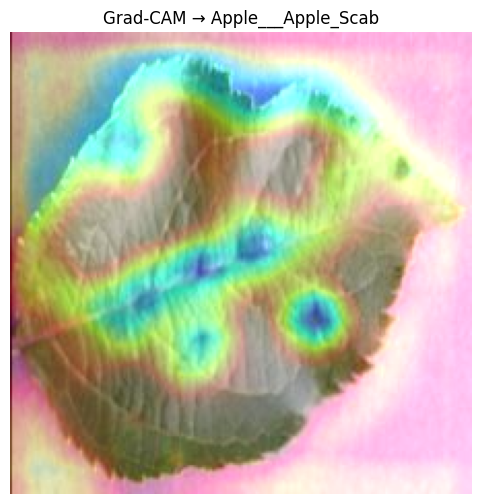

In [37]:
# Load best model
model.load_state_dict(torch.load("best_crop_model.pth"))
model.eval()

# Target layer = last convolution block
target_layer = model.stage4[3]  # Conv2 before MaxPool

gradcam = GradCAM(model, target_layer)

# Get one batch
images, labels = next(iter(valid_loader))
images, labels = images.to(device), labels.to(device)

# Pick one image
idx = 0
input_img = images[idx].unsqueeze(0)

cam = gradcam.generate(input_img)
show_gradcam(images[idx], cam, labels[idx].item(), train_data.classes)


In [46]:
torch.save(model.state_dict(), "best_crop_model.pth")